In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

import os
from tqdm import tqdm

import torch
from torch import nn
from torchvision import datasets, transforms
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import gc

import cv2

device = torch.device("cuda:0")
print(device)

C:\Users\april\Anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda:0


In [2]:
img_shape = (224,224)

train_dir = "D:/Projects/covid-detection-system/Data/train"
test_dir = "D:/Projects/covid-detection-system/Data/test"

(2000, 2000)


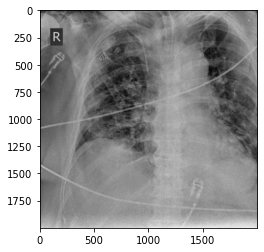

In [3]:
img = cv2.imread(train_dir + '/COVID19/COVID19(0).jpg', cv2.IMREAD_GRAYSCALE)
print(img.shape)
plt.imshow(img, cmap='gray')
plt.show()

In [4]:
transforms_train = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize(img_shape),
    transforms.RandomHorizontalFlip(p = 0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean = 0, std = 255)
])

transforms_test = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize(img_shape),
    transforms.ToTensor(),
    transforms.Normalize(mean = 0, std = 255)
])


In [5]:
split = 0.3
dataset = datasets.ImageFolder(train_dir, transform=transforms_train)
#training and validation split
n_samples = len(dataset)
train_dataset, validation_dataset = torch.utils.data.random_split(dataset, [n_samples - int(split*n_samples), int(split*n_samples)])
test_dataset = datasets.ImageFolder(test_dir, transform=transforms_test)

In [6]:
n_samples_train = len(train_dataset)
n_samples_val = len(validation_dataset)
n_samples_test = len(test_dataset)
print(n_samples_train, n_samples_val, n_samples_test)

3601 1543 1288


In [7]:
class Net(nn.Module):
    def __init__(self, input_shape):
        '''
        input_shape: shape of input image
        '''
        super().__init__()
        self.layers = nn.Sequential(
            #block 1
            nn.Conv2d(1, 64, kernel_size=(3,3), padding=(1,1)),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Conv2d(64, 64, kernel_size=(3,3), padding=(1,1)),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            
            #block 2
            nn.MaxPool2d(kernel_size = (2,2), stride = (2,2)),
            nn.Conv2d(64, 128, kernel_size=(3,3), padding=(1,1)),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.Conv2d(128, 128, kernel_size=(3,3), padding=(1,1)),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            
            #block 3
            nn.MaxPool2d(kernel_size = (2,2), stride = (2,2)),
            nn.Conv2d(128, 256, kernel_size=(3,3), padding=(1,1)),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.Conv2d(256, 256, kernel_size=(3,3), padding=(1,1)),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.Conv2d(256, 256, kernel_size=(3,3), padding=(1,1)),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            
            #block 4
            nn.MaxPool2d(kernel_size = (2,2), stride = (2,2)),
            nn.Conv2d(256, 512, kernel_size=(3,3), padding=(1,1)),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(),
            nn.Conv2d(512, 512, kernel_size=(3,3), padding=(1,1)),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(),
            nn.Conv2d(512, 512, kernel_size=(3,3), padding=(1,1)),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(),
            
            #block 5
            nn.MaxPool2d(kernel_size = (2,2), stride = (2,2)),
            nn.Conv2d(512, 512, kernel_size=(3,3), padding=(1,1)),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(),
            nn.Conv2d(512, 512, kernel_size=(3,3), padding=(1,1)),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(),
            nn.Conv2d(512, 512, kernel_size=(3,3), padding=(1,1)),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(),
            
            nn.MaxPool2d(kernel_size = (2,2), stride = (2,2)),
            nn.Flatten(),
            nn.Linear(int((input_shape[0]*input_shape[1])/2), 4096),
            nn.LeakyReLU(),
            nn.Linear(4096, 3),
            nn.Sigmoid()
        )
        
    def forward(self, X):
        return self.layers(X)

In [8]:
#initialize the model
net = Net(img_shape).to(device)

lr = 1e-2
batch_size = 8
criterion = nn.CrossEntropyLoss()
# criterion = nn.BCEWithLogitsLoss()
epochs = 10
optimizer = torch.optim.SGD(net.parameters(), lr = lr) #optimizer

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

training_history = [[],[]] #loss, accuracy
validation_history = [[],[]] #loss, accuracy

In [13]:
#training loop
for epoch in range(epochs):
    train_loss, val_loss = 0.0, 0.0
    train_correct, val_correct = 0, 0
    #model training
    for images, labels in tqdm(train_dataloader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = net(images)
        loss = criterion(outputs, labels)
        
        with torch.no_grad():
            train_correct += torch.sum(torch.argmax(outputs, axis=1) == labels)
            
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
    with torch.no_grad():        
        #calculate loss and accuracy on validation set    
        for images, labels in tqdm(validation_dataloader):
            images = images.to(device)
            labels = labels.to(device)
            
            #Forward pass
            outputs = net(images)
            loss = criterion(outputs, labels)
            
            val_correct += torch.sum(torch.argmax(outputs, axis=1) == labels)      
            val_loss += loss.item()
            
    
    train_loss = train_loss/len(train_dataloader)
    val_loss = val_loss/len(validation_dataloader)
    train_acc = train_correct/n_samples_train
    val_acc = val_correct/n_samples_val
    
    training_history[0].append(train_loss)
    validation_history[0].append(val_loss)
    
    training_history[1].append(train_acc.to('cpu'))
    validation_history[1].append(val_acc.to('cpu'))

    print(f"[{epoch}/{epochs}] epoch, training loss: {train_loss:.5f} and training accuracy: {train_acc:.5f}, validation loss: {val_loss:.5f} and validation accuracy: {val_acc:.5f}")

100%|████████████████████████████████████████████████████████████████████████████████| 193/193 [00:46<00:00,  4.12it/s]


[0/10] epoch, training loss: 0.56594 and training accuracy: 0.98584, validation loss: 0.59321 and validation accuracy: 0.95787


100%|████████████████████████████████████████████████████████████████████████████████| 193/193 [00:47<00:00,  4.09it/s]


[1/10] epoch, training loss: 0.56613 and training accuracy: 0.98528, validation loss: 0.59315 and validation accuracy: 0.95528


100%|████████████████████████████████████████████████████████████████████████████████| 193/193 [00:46<00:00,  4.19it/s]


[2/10] epoch, training loss: 0.56504 and training accuracy: 0.98750, validation loss: 0.58889 and validation accuracy: 0.96047


100%|████████████████████████████████████████████████████████████████████████████████| 193/193 [00:46<00:00,  4.19it/s]


[3/10] epoch, training loss: 0.56487 and training accuracy: 0.98778, validation loss: 0.59454 and validation accuracy: 0.95463


100%|████████████████████████████████████████████████████████████████████████████████| 193/193 [00:48<00:00,  4.01it/s]


[4/10] epoch, training loss: 0.56350 and training accuracy: 0.98834, validation loss: 0.59042 and validation accuracy: 0.95982


100%|████████████████████████████████████████████████████████████████████████████████| 193/193 [00:43<00:00,  4.39it/s]


[5/10] epoch, training loss: 0.56501 and training accuracy: 0.98695, validation loss: 0.59231 and validation accuracy: 0.96047


100%|████████████████████████████████████████████████████████████████████████████████| 193/193 [00:43<00:00,  4.41it/s]


[6/10] epoch, training loss: 0.56321 and training accuracy: 0.98861, validation loss: 0.58786 and validation accuracy: 0.96241


100%|████████████████████████████████████████████████████████████████████████████████| 193/193 [00:43<00:00,  4.46it/s]


[7/10] epoch, training loss: 0.56044 and training accuracy: 0.99111, validation loss: 0.58881 and validation accuracy: 0.96241


100%|████████████████████████████████████████████████████████████████████████████████| 193/193 [00:44<00:00,  4.37it/s]


[8/10] epoch, training loss: 0.55983 and training accuracy: 0.99111, validation loss: 0.59041 and validation accuracy: 0.95723


100%|████████████████████████████████████████████████████████████████████████████████| 193/193 [00:44<00:00,  4.34it/s]

[9/10] epoch, training loss: 0.55897 and training accuracy: 0.99334, validation loss: 0.58658 and validation accuracy: 0.96565


In [15]:
torch.save(net.state_dict(), 'model.pt')

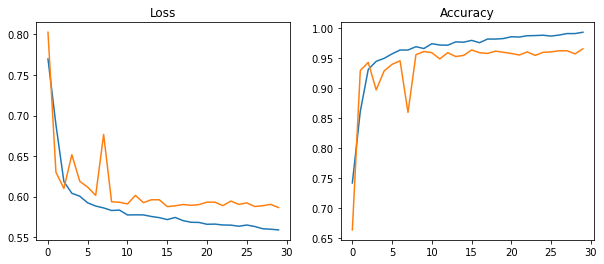

In [14]:
fig, ax = plt.subplots(1,2, figsize = (10,4))
training_loss, training_acc = training_history
validation_loss, validation_acc = validation_history
ax[0].set_title("Loss")
ax[0].plot(training_loss)
ax[0].plot(validation_loss)

ax[1].set_title("Accuracy")
ax[1].plot(training_acc)
ax[1].plot(validation_acc)

plt.show()
# plt.savefig('/content/drive/MyDrive/Reviews_data/labelled_reviews/models/2.0/loss.png')

# Testing

In [22]:
images, _ = next(iter(test_dataloader))
net = Net(images[0][0].shape).to(device)
net.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

In [24]:
test_correct = 0
with torch.no_grad():
    for images, labels in tqdm(test_dataloader):
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = net(images)
            loss = criterion(outputs, labels)


            test_correct += torch.sum(torch.argmax(outputs, axis=1) == labels)
            
accuracy = test_correct/n_samples_test
print(f'accuracy: {accuracy:.5f}')

100%|████████████████████████████████████████████████████████████████████████████████| 161/161 [00:40<00:00,  4.02it/s]


accuracy: 0.96118
